1.744720501755479


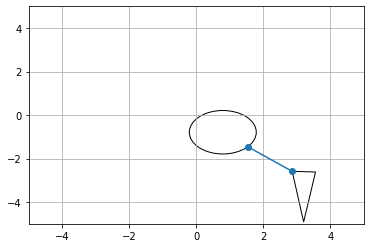

In [32]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt


BITSETS = np.array([0b001, 0b010, 0b100, 0b011, 0b101, 0b110, 0b111])


def set_bit(b, i):
    ''' Set bit i in b to one. '''
    return b | (1 << i)


def unset_bit(b, i):
    ''' Set bit i in b to zero. '''
    return b & ~(1 << i)


def get_bit(b, i):
    '''Get the value of the bit at index i in b. '''
    return b & (1 << i)


def bit_indices(b, length=3):
    ''' Get the indices of set bits in b, up to length bits. '''
    mask = 1 << np.array(range(length))
    return np.nonzero(b & mask != 0)[0]


def find_first_set(b):
    ''' Return the index of the first one bit in b. '''
    return int(np.log2(b & -b))


def find_first_unset(b):
    ''' Return the index of the first zero bit in b. '''
    return find_first_set(~b)


class Polygon:
    def __init__(self, vertices):
        # vertices stored as 2xn matrix
        self.vertices = vertices

    def support(self, d):
        ''' Return the point in the shape that has the highest dot product with
            unit vector d. '''
        # this is always one of the vertices
        idx = np.argmax(d.dot(self.vertices))
        return self.vertices[:, idx]


class Circle:
    def __init__(self, c, r):
        self.c = c
        self.r = r

    def support(self, d):
        return self.c + self.r * d / np.linalg.norm(d)


def gjk(shape1, shape2, a0=np.array([1, 0]), eps=0.001):
    ''' Gilbert-Johnson-Keerthi distance algorithm.
        Parameters:
            shape1, shape2: shapes to calculate distance between
            a0: arbitrary initial direction
        Returns:
            Distance between the shapes (0 if they intersect),
            points v1, v2 representing the closest points on the first and
            second shapes, respectively. '''
    # arbitrary point in Minoski diff
    v = shape1.support(a0) - shape2.support(-a0)

    # direction to origin from closest point
    a = shape1.support(-v)
    b = shape2.support(v)
    w = a - b

    # initialize simplex
    S = np.zeros((2, 3))
    bitset = 0

    # to compute the closest points on the shapes, in addition to the distance,
    # we need to keep track of the points from each shape used to compute the
    # simplex
    S1 = np.zeros((2, 3))
    S2 = np.zeros((2, 3))

    # iterate until w is no more extreme in the direction v than v itself
    while v.dot(v) - v.dot(w) > eps:
        # add new point to simplex
        i = find_first_unset(bitset)
        bitset = set_bit(bitset, i)
        S[:, i] = w
        S1[:, i] = a
        S2[:, i] = b

        # compute closest point to the origin in the simplex, as well the
        # smallest simplex that supports that point
        v, bitset, contains_origin, coeffs = johnson(S, bitset)

        if contains_origin:
            break

        # recompute direction
        a = shape1.support(-v)
        b = shape2.support(v)
        w = a - b

    # compute closest points using the same coefficients as the closest point
    # of the Minowski diff to the origin v
    idx = bit_indices(bitset)
    v1 = coeffs.dot(S1[:, idx].T)
    v2 = coeffs.dot(S2[:, idx].T)

    distance = np.sqrt(v.dot(v))

    return distance, v1, v2


def johnson(points, this_bitset):
    ''' Johnson distance algorithm
        Parameters:
            points: 2x3 matrix of points in the simplex
            this_bitset: 3-bit number representing the active members of the
                simplex
        Returns:
            v: the closest point of this simplex to the origin
            bitset: the bitset of the smallest sub-simplex supporting v
            contains_origin: True if the sub-simplex contains the origin
            coeffs: Coefficients for the points in the sub-simplex to v via
                convex combination '''
    # store deltas: row is indexed by the points in the set X; column indexed
    # by delta index
    # {y1} represented by 001, {y2} by 010, etc
    D = np.zeros((8, 3))

    # singleton sets are unity
    D[0b001, 0] = 1
    D[0b010, 1] = 1
    D[0b100, 2] = 1

    # calculate deltas
    # this implementation requires bitset array to be ordered in increasing
    # number of bits
    for bitset in BITSETS:
        if bitset & this_bitset != bitset:
            continue

        for i in range(3):
            bitset_no_i = unset_bit(bitset, i)
            if bitset_no_i != 0 and get_bit(bitset, i):
                k = find_first_set(bitset_no_i)
                yk = points[:, k]
                yi = points[:, i]
                D[bitset, i] = np.sum([ D[bitset_no_i, j] * (yk - yi).dot(points[:, j]) for j in bit_indices(bitset_no_i) ])

    for bitset in BITSETS:
        # only iterate bit sets that contain members of the current bitset
        if bitset & this_bitset != bitset:
            continue

        # check conditions for this bit set to contain the closest point
        contains_closest_pt = True
        for j in range(3):
            if get_bit(bitset, j) and D[bitset, j] <= 0:
                contains_closest_pt = False
            elif not get_bit(bitset, j) and D[set_bit(bitset, j), j] > 0:
                contains_closest_pt = False

        if contains_closest_pt:
            idx = bit_indices(bitset)
            coeffs = D[bitset, idx] / np.sum(D[bitset, idx])
            v = coeffs.dot(points[:, idx].T)
            contains_origin = (bitset == 0b111)
            return v, bitset, contains_origin, coeffs


def main():
    # test shapes
    c = np.random.random(2)*8-4
#     shape1 = Circle(c=c, r=1)
#     shape2 = Circle(c=c, r=2)
    shape1 = Circle(c=np.random.random(2)*8-4, r=1)
    shape2 = Polygon(np.random.random((2, 3)) * 10 - 5)

    # calculate distance and closest points on shapes
    d, v1, v2 = gjk(shape1, shape2)
    print(d)

    # plot shapes and the closest points between them
    fig, ax = plt.subplots(1)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    ax.add_patch(plt.Circle(shape1.c, shape1.r, fill=False))
#     ax.add_patch(plt.Circle(shape2.c, shape2.r, fill=False))
    ax.add_patch(plt.Polygon(shape2.vertices.T, color='k', fill=False, closed=True))
    plt.plot([v1[0], v2[0]], [v1[1], v2[1]], '-o')
    plt.grid()
    plt.show()

main()